## Plot mean chlorophyll concentration from the calc_chlor.ipynb dataframe

The calc_chlor.ipynb notebook needs to be run first to create the file chlor_pandas.h5

In [1]:
import h5py
import pandas as pd
import pyproj
import rasterio
import numpy as np
import e582utils.bin_calc as bc
from e582lib.map_slices import make_basemap_xy
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings("ignore")

#### read in the pandas dataframe written by calc_chlor.ipynb

In [2]:
pandas_df='chlor_pandas.h5'
with pd.HDFStore(pandas_df,'r') as store:
    the_df=store['chlor_a_mean']
meta_dict=dict()
with  h5py.File(pandas_df,'r') as f:
    for key in f.attrs.keys():
        try:
            meta_dict[key]=f.attrs[key]
        except OSError:
            pass
    for key in f['chlor_a_mean'].attrs.keys():
        #print(key,f['chlor_a_mean'].attrs['mean_title'])
        try:
            meta_dict[key]=f['chlor_a_mean'].attrs[key]
        except (OSError,KeyError) as e:
            #print('bad luck with {}'.format(key))
            pass
print(meta_dict)

{'ndim': 2, 'created_on': 'Sun Feb 12 08:59:03 2017', 'variance_title': 'variance of chlorophyll concentration', 'end_date': '2010-07-01', 'start_date': '2010-06-01', 'variance_units': '(micrograms/m^3)^2', 'mean_units': 'micrograms/m^3', 'mean_title': 'mean chlorophyll concentration', 'nblocks': 1, 'history': 'created by chlorophyl.ipynb'}


In [3]:
the_df.head()

,chlor_a_mean,chlor_a_var
binnum,,
3430810,1.476212,3.389754e-02
3430811,1.878990,-5.140521e-09
3430812,1.722063,-8.872907e-08
3436885,1.364124,1.471481e-02
3436886,1.446847,3.364159e-02


#### define a whole disk the map projection 

In [4]:
basemap_args=dict(projection='ortho',lon_0=-130,lat_0=0,resolution='c')
bmap=Basemap(**basemap_args)
ll_x,ll_y = bmap.llcrnrx,bmap.llcrnry
ur_x,ur_y = bmap.urcrnrx,bmap.urcrnry

#### get the affine transform for the basemap corners

In [5]:
from rasterio.transform import from_bounds
width=500
height=500
transform = from_bounds(ll_x, ll_y, ur_x, ur_y, width, height)
transform

Affine(25483.988, 0.0, 0.0,
       0.0, -25483.988, 12741994.0)

In [6]:
chlor_array=np.empty([height,width],dtype=np.float32)
chlor_array[...]=np.nan

#### Now go through every row,col and look up the mean concentration from the dataframe, indexed by bin number

If and x,y coordinate doesn't translate to a bounded lat/lon (i.e. if the projection
says it can't appear on the map and returns lat=lon=1.e30), then skip it.

In [7]:
num_rows=4320
find_bin=bc.Bin_calc(num_rows)
for row in range(height):
    for col in range(width):
        xcell,ycell = transform*(col,row)
        lon, lat = bmap(xcell,ycell,inverse=True)
        if np.abs(lon) > 180 or np.abs(lat) >  90:
            continue
        bin_num=find_bin.lonlat2bin(lon,lat)        
        try:
            chlor_array[row,col]=float(the_df.loc[bin_num]['chlor_a_mean'])
            #print(lon,lat,bin_num,chlor_array[row,col])
        except KeyError:
            pass
chlor_array = np.ma.masked_invalid(chlor_array)

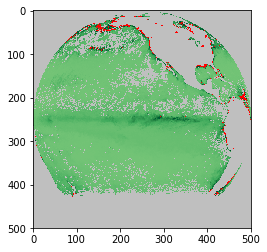

In [8]:
%matplotlib inline
cmap=cm.YlGn  #see http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
cmap.set_over('r')
cmap.set_under('b')
cmap.set_bad('0.75') #75% grey
vmin= -1.5
vmax= 1.5
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
fig,ax=plt.subplots(1,1)
ax.imshow(chlor_array,cmap=cmap,norm=the_norm);

#### Plot the map

In [9]:
left_col=0
right_col=width
top_row=0
bot_row=height
rownums=np.arange(0,height)
colnums=np.arange(0,width)
xline=[]
yline=[]
for the_col in colnums:
    x,y = transform*(the_col,0)
    xline.append(x)
for the_row in rownums:
    x,y= transform*(0,the_row)
    yline.append(y)
xline,yline=np.array(xline),np.array(yline)
xvals, yvals = np.meshgrid(xline,yline)

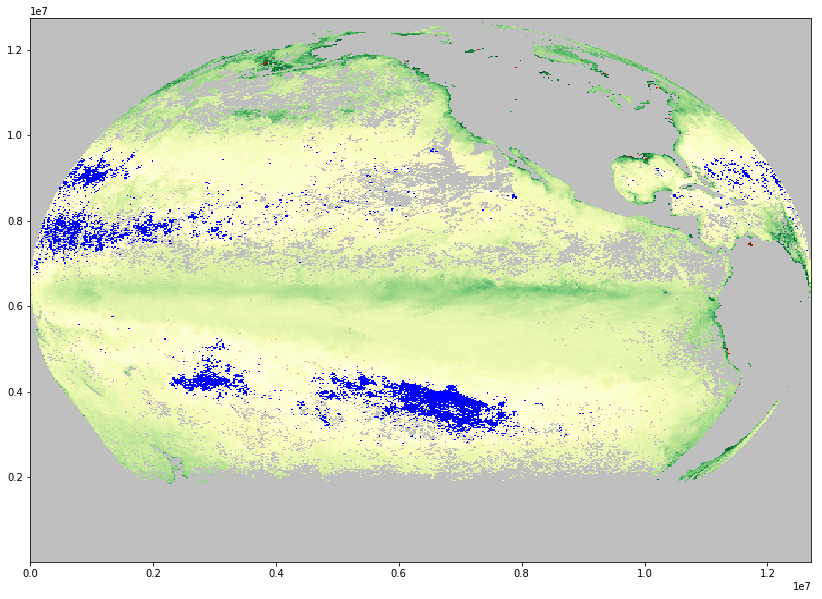

In [10]:
fig,ax = plt.subplots(1,1,figsize=(14,10))
cmap=cm.YlGn  #see http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
cmap.set_over('r')
cmap.set_under('b')
cmap.set_bad('0.75') #75% grey
vmin= -1.5
vmax= 1.5
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
ax.pcolormesh(xvals,yvals,np.log10(chlor_array),cmap=cmap,norm=the_norm);

                Geostationary, Orthographic or Azimuthal equidistant basemap
                

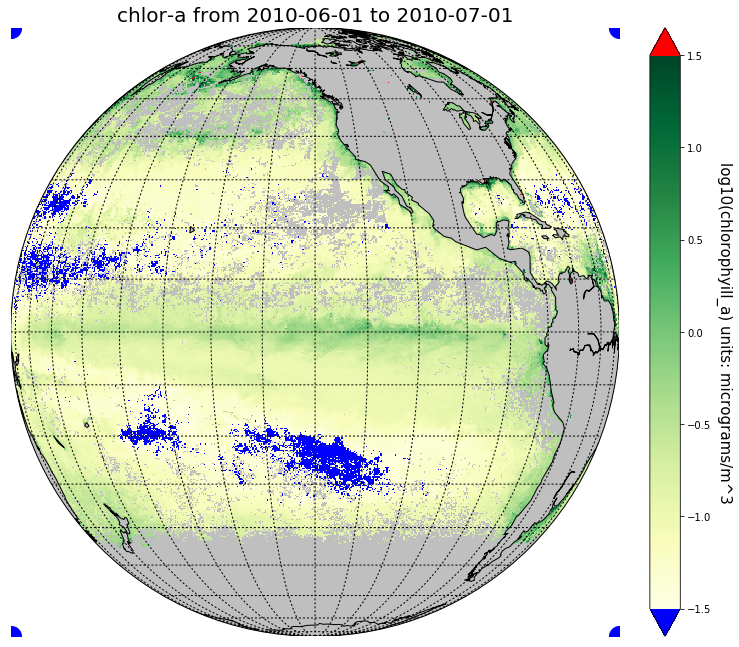

In [11]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(12,12))
basemap_args['ax']=ax
basemap_args['resolution']='c'
bmap = Basemap(**basemap_args)
cmap=cm.YlGn  #see http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
cmap.set_over('r')
cmap.set_under('b')
cmap.set_bad('0.75') #75% grey
vmin= -1.5
vmax= 1.5
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
parallels=np.arange(-80, 80, 10)
meridians=np.arange(-180, 180, 10)
CS=bmap.pcolormesh(xvals, yvals, np.log10(chlor_array), cmap=cmap,norm=the_norm)
CBar=bmap.colorbar(CS, 'right', size='5%', pad='5%',extend='both')
CBar.set_label('log10(chlorophyill_a) units: {mean_units:}'.format_map(meta_dict),
               rotation=-90,va='bottom',size=15)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90)
ax.set_title('chlor-a from {start_date:} to {end_date:}'.format_map(meta_dict),size=20)
bmap.drawcoastlines();
ax.plot(bmap.urcrnrx,bmap.urcrnry,'bo',markersize=20)
ax.plot(bmap.urcrnrx,0,'bo',markersize=20)
ax.plot(0,bmap.urcrnry,'bo',markersize=20)
ax.plot(0,0,'bo',markersize=20);

In [12]:
bmap.projparams

{'R': 6370997.0,
 'lat_0': 0.01,
 'lon_0': -130.0,
 'proj': 'ortho',
 'units': 'm',
 'x_0': 6370997.0,
 'y_0': 6370997.0}